In [54]:
'''
Extract all the .wav files from the IEMOCAP database and prepare them for
training with the CNN

Isolate each file
Convert to LPMS (better representation for audio deep learning)
Remove silence
Chop into 0.4 second chunks
Final representation will be nRows,nCols,nDims = 20, 25, 1
Total number of instances worked out to be 2,146,661
'''
# Import libraries
import os
import matplotlib.pyplot as plt

# Storage
import pickle

# Audio functions
import librosa as lib

# Play a file
import simpleaudio as sa

# Normalise data
from sklearn.preprocessing import MinMaxScaler

# include extract_audio_emodb for munging functions
import extract_audio_emodb

In [13]:
'''
MUNGING FUNCTIONS
'''

# Load a file
def load_file(filepath):
    '''
    Load a file, return the samples
    '''
    
    # get datapoints and sample rate of file and load it
    samples, sr = lib.load(filepath, sr=None)
    
    return samples

# Plot a wav
def plot_raw_wave(file):
    '''
    Plot the raw wave
    '''
    plt.figure(figsize=(14, 5))
    lib.display.waveplot(file, sr=16000)

# Plot an LPMS representation
def plot_lpms_chunk(win):
    '''
    Plot lpms instance chunk
    '''
    lib.display.specshow(win,
                         sr=16000,
                         x_axis='s',
                         y_axis='linear',
                         hop_length=256)
    plt.colorbar(format='%+2.0f dB')

# Play a file
def play_file(file):
    '''
    Play a file
    '''
    wave_obj = sa.WaveObject.from_wave_file(file)
    play_obj = wave_obj.play()
    # Wait until sound has finished playing
    play_obj.wait_done()

'''
STRIP THE SILENCE
'''
def strip_silence(file_to_strip):
    '''
    Takes a non-treated file and strips silent segments from it - provides an
    array as final output
    '''
    intervals = lib.effects.split(file_to_strip,
                                      top_db=30,
                                      frame_length=1024,
                                      hop_length=256)
    
    # compile non silent parts to a list of lists
    non_silent = []
    for i in range(intervals.shape[0]):
        chunk = file_to_strip[intervals[i][0]:intervals[i][1]]
        non_silent.append(chunk)
    
    # flatten list of lists to a single list
    non_silent_arr = [item for sublist in non_silent for item in sublist]
    
    return np.asarray(non_silent_arr)

'''
CONVERT TO LPMS
'''
def convert_to_lpms(raw_silenced):
    '''
    Take a raw wave with the silence removed and convert to a LPMS matrix
    '''
    log_pow = lib.feature.melspectrogram(y=raw_silenced,
                                             sr=16000,
                                             n_mels=40, 
                                             win_length=1024,
                                             hop_length=256)
    
    # scale to dB
    log_pow_db = lib.power_to_db(log_pow, ref=np.max)
    
    return log_pow_db

'''
CHUNK THE FILE TO 0.4 sec CHUNKS
SCALE THE CONTENTS
SAVE INDIVIDUAL INSTANCES WITH APPROPRIATE LABELS
'''
def chunk_scale_lpms_matrix(lpms_matrix, data_list, names_list, name):
    '''
    Split the LPMS matrix up into 0.4 second chunks
    '''
    
    # to track chunks
    track_start = 0
    track_end = 25
    
    # define scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # taking the lower 20 bins
    # step through the instance extracting 0.4 sec length chunks
    while track_end < lpms_matrix.shape[1]:
        
        # get window data
        win = lpms_matrix[20:40, track_start:track_end]
        
        # scale the data
        win_scaled = scaler.fit_transform(win)
        
        # append data and labels
        data_list.append(win_scaled)
        names_list.append(name)
        
        # increment start and end of chunks
        track_start += 1
        track_end += 1

In [6]:
'''
Read in the wav filenames so we can reference labels
'''

# For demonstration purposes just going to read in one Session
sess = [1]  # [1, 2, 3, 4, 5]

wav_names = []
wav_samples = []

for digit in sess:
    wav_folder = "/Users/billcoleman/NOTEBOOKS/DublinAI/nlp_emotion/data/IEMOCAP_full_release/Session" + str(digit) + "/sentences/wav"
    print(wav_folder)

    # for every folder in wav_folder
    for f in os.listdir(wav_folder):
        if f == ".DS_Store":
            continue
        # for every file in each folder
        # print(f)
        for e in os.listdir(str(wav_folder + '/' + f)):
            # if the file extension is .wav
            if e[-4:] != ".wav":
                continue
    
            # Make path to file
            file_to_load = str(wav_folder + '/' + f + '/' + e)
            # Read the file samples
            file_samples = load_file(file_to_load)
            # Strip silence
            silence_stripped = strip_silence(file_samples)
            # Return LPMS 40 mels, 16 kHz
            lpms_ified = convert_to_lpms(silence_stripped)
            # Scaled the data, chunk to 0.4 secs
            chunk_scale_lpms_matrix(lpms_ified, wav_samples, wav_names, e)
            
        print("Length of wav_names: ", len(wav_names))
        print("Length of wav_samples: ", len(wav_samples))

/Users/billcoleman/NOTEBOOKS/DublinAI/nlp_emotion/data/IEMOCAP_full_release/Session1/sentences/wav
Length of wav_names:  5550
Length of wav_samples:  5550
Length of wav_names:  14729
Length of wav_samples:  14729
Length of wav_names:  22354
Length of wav_samples:  22354
Length of wav_names:  34733
Length of wav_samples:  34733
Length of wav_names:  48170
Length of wav_samples:  48170
Length of wav_names:  63064
Length of wav_samples:  63064
Length of wav_names:  73213
Length of wav_samples:  73213
Length of wav_names:  92781
Length of wav_samples:  92781
Length of wav_names:  99314
Length of wav_samples:  99314
Length of wav_names:  122413
Length of wav_samples:  122413
Length of wav_names:  137169
Length of wav_samples:  137169
Length of wav_names:  160097
Length of wav_samples:  160097
Length of wav_names:  175177
Length of wav_samples:  175177
Length of wav_names:  192696
Length of wav_samples:  192696
Length of wav_names:  201400
Length of wav_samples:  201400
Length of wav_names: 

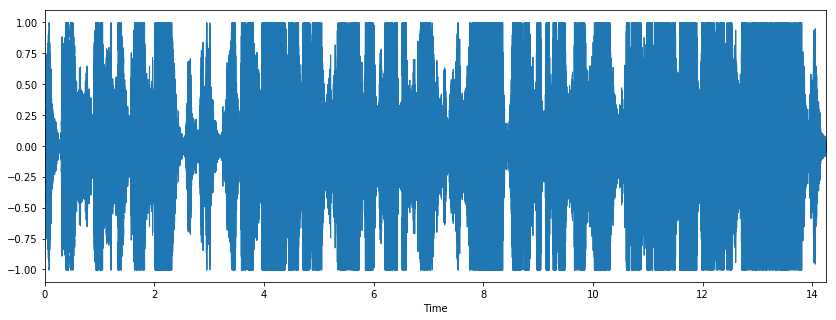

In [14]:
# Lets do some plotting to visualise the wavs.
# Make path to file
file_to_load = str(wav_folder + '/' + f + '/' + e)
# Read the file samples
file_samples = load_file(file_to_load)

# This is the full-length raw wav
plot_raw_wave(file_samples)

'''
Each wav varies considerably in length, this one is quite long - ~14 seconds
'''

In [58]:
# Play the file - make sure your volume is down they're shouting!
play_file(wav_folder + '/' + f[:-4] + '/' + e)

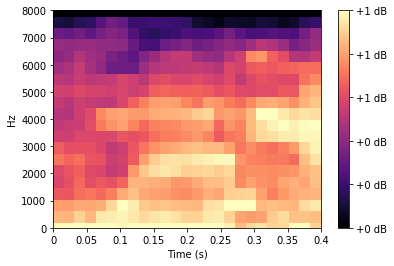

In [40]:
# Wach wav is chopped up into windows of 0.4 seconds in length. After that we convert them to Log Power Mel 
# Spectrograms (LPMS) for CNN input

# This is the LPMS representation
plot_lpms_chunk(wav_samples[300])

In [1]:
'''
Now we'll extract label and transcription data from the IEMOCAP dataset.
'''

# Import some libraries
import pandas as pd
import numpy as np

In [2]:
'''
In .wav extraction and chunking into LPMS we've ended up with ~2 million instances
We need to match the .wav filenames to each instance as a way of tagging each instance to the correct label
Step through every rating file in each folder
Pull out the instance reference
Pull out the VAD labels
Then amalgamate the ratings (average over all oracle raters and self ratings)
'''

sess = [1, 2, 3, 4, 5]

labels = []

for digit in sess:
    ev_subject = "/Users/billcoleman/NOTEBOOKS/DublinAI/nlp_emotion/data/IEMOCAP_full_release/Session" + str(digit) + "/dialog/EmoEvaluation/"

    '''
    Loop through all the folders that have evaluation information, pulling all
    ratings out and storing them in a list
    '''
    
    # for every file in this folder
    for f in os.listdir(ev_subject):
        
        # if it picks this up, skip to the next
        if f == "Attribute" or f == "Self-evaluation":
    
            print("FOLDER: ", f)
            
            # there are three folders here, for each of them
            for s in os.listdir(str(ev_subject + '/' + f)):
        
                # look at each text file that ends like this
                # if the file extension is atr.txt
                if s[-7:] != "atr.txt":
                    continue
                print("FILE: ", s)
                
                # open the file
                file = open(str(ev_subject + '/' + f + '/' + s))
                
                # Read each line in the file and append to an object
                while True:
                    
                    # while there's a line to read, read it
                    this_line = file.readline()
                    
                    # if we've reached the end of the file
                    if not this_line:
                        break
                    
                    # append the line to the list
                    labels.append(this_line)

FOLDER:  Attribute
FILE:  Ses01F_impro01_e3_atr.txt
FILE:  Ses01F_impro01_e4_atr.txt
FILE:  Ses01F_impro02_e3_atr.txt
FILE:  Ses01F_impro02_e4_atr.txt
FILE:  Ses01F_impro03_e1_atr.txt
FILE:  Ses01F_impro03_e2_atr.txt
FILE:  Ses01F_impro03_e3_atr.txt
FILE:  Ses01F_impro04_e1_atr.txt
FILE:  Ses01F_impro04_e2_atr.txt
FILE:  Ses01F_impro05_e3_atr.txt
FILE:  Ses01F_impro05_e4_atr.txt
FILE:  Ses01F_impro06_e1_atr.txt
FILE:  Ses01F_impro06_e2_atr.txt
FILE:  Ses01F_impro07_e1_atr.txt
FILE:  Ses01F_impro07_e2_atr.txt
FILE:  Ses01F_script01_1_e1_atr.txt
FILE:  Ses01F_script01_1_e2_atr.txt
FILE:  Ses01F_script01_1_e3_atr.txt
FILE:  Ses01F_script01_2_e1_atr.txt
FILE:  Ses01F_script01_2_e2_atr.txt
FILE:  Ses01F_script01_3_e1_atr.txt
FILE:  Ses01F_script01_3_e2_atr.txt
FILE:  Ses01F_script01_3_e3_atr.txt
FILE:  Ses01F_script02_1_e3_atr.txt
FILE:  Ses01F_script02_1_e4_atr.txt
FILE:  Ses01F_script02_2_e3_atr.txt
FILE:  Ses01F_script02_2_e4_atr.txt
FILE:  Ses01F_script03_1_e3_atr.txt
FILE:  Ses01F_scri

In [3]:
'''
We're going to use these tags to pull out 'VAD' labels - valence, activation, dominance
'''
label_split = []
label_tags = []
label_val = []
label_act = []
label_dom = []

# Split data by :
# Step through the list of labels
for i in range(len(labels)):
    # split the instance by :
    splits = labels[i].split(":")
    # append to a list
    label_split.append(splits)
    # split the tag by whitespace then append to list
    label_tags.append(splits[0].split())
    # Get val label
    label_val.append(float(splits[2][4]))
    # Get act label
    label_act.append(float(splits[1][4]))
    # Get dom label
    if (len(splits) > 3):
        label_dom.append(float(splits[3][4]))
    else:
        label_dom.append(np.NaN)

In [18]:
# Check the spread of labels - how many NANs in label_dom
print(np.unique(label_dom, return_counts=True))
print(np.unique(label_act, return_counts=True))
print(np.unique(label_val, return_counts=True))

(array([ 1.,  2.,  3.,  4.,  5., nan, nan, nan]), array([1289, 4281, 9245, 6935, 2097,    1,    1,    1]))
(array([1., 2., 3., 4., 5.]), array([1218, 6443, 9807, 5946,  436]))
(array([1., 2., 3., 4., 5.]), array([1018, 5093, 7659, 8271, 1809]))


In [19]:
# Replace the 3 NaNs in dom after splitting into train/test
# Make a dataframe with all this stuff
labels_df = pd.DataFrame([label_tags, label_val, label_act, label_dom, label_split, labels],
                         dtype=float).T
labels_df.columns = ['label_tags', 'label_val', 'label_act', 'label_dom', 'label_split', 'labels']

In [20]:
# check unique instances in wav_names and labels_tags
# How many unique instances are there?
uniq_tags_list, uniq_tags_ct = np.unique(label_tags, return_counts=True)
print("No. of unique tags: ", len(uniq_tags_list))
uniq_wavs_list, uniq_wavs_ct = np.unique(wav_names, return_counts=True)
print("No. of unique wavs: ", len(uniq_wavs_list))

No. of unique tags:  10039
No. of unique wavs:  1819


In [21]:
# Step through labels_df and chop 'label_tags' so we can match it easily with the wavs
label_tags_str = []
for i in range(labels_df.shape[0]):
    label_tags_str.append(labels_df['label_tags'][i][0])
    
labels_df['label_tags_str'] = label_tags_str

In [22]:
# Step through the unique wavs list and aggregate VAD scores for each
uniq_wavs_tags = []
for i in range(len(uniq_wavs_list)):
    # Chop the '.wav' off the end of each filename
    uniq_wavs_tags.append(uniq_wavs_list[i][:-4])
    
# Make a dataframe with both of these
uniq_wavs_df = pd.DataFrame([uniq_wavs_list, uniq_wavs_tags]).T
uniq_wavs_df.columns=['uniq_wavs_list', 'uniq_wavs_tags']

In [24]:
# Get means of labels for instances
# Getting 'No numeric types to aggregate' error so had to do this the long way around
act_sum = labels_df.groupby('label_tags_str')['label_act'].sum()
act_count = labels_df.groupby('label_tags_str')['label_act'].count()
act_mean = act_sum / act_count
val_sum = labels_df.groupby('label_tags_str')['label_val'].sum()
val_count = labels_df.groupby('label_tags_str')['label_val'].count()
val_mean = val_sum / val_count
dom_sum = labels_df.groupby('label_tags_str')['label_dom'].sum()
dom_count = labels_df.groupby('label_tags_str')['label_dom'].count()
dom_mean = dom_sum / dom_count

In [38]:
# Get all labels together
labels_mean = pd.DataFrame([val_mean, act_mean, dom_mean]).T
labels_mean.columns = ['val_mean', 'act_mean', 'dom_mean']

# Join tags of unique wavs to VAD averages
labels_mean_wavs = pd.DataFrame(labels_mean, index=uniq_wavs_tags)

# This gives us a dataframe that stores 
labels_mean.head()

,val_mean,act_mean,dom_mean
label_tags_str,,,
Ses01F_impro01_F000,3.333333,3.666667,2.000000
Ses01F_impro01_F001,3.666667,3.333333,2.333333
Ses01F_impro01_F002,3.333333,3.333333,2.666667
Ses01F_impro01_F003,3.666667,3.000000,3.000000
Ses01F_impro01_F004,3.333333,2.666667,2.666667


In [39]:
print(labels_mean.shape)

(10039, 3)


In [41]:
'''
Isolating the transcriptions for each wav instance
Pull out the instance reference & transcription

Then amalgamate with ratings
'''
# Again going to do one session only for demonstrative purposes
sess = [1]  # [1, 2, 3, 4, 5]

transcriptions = []

for digit in sess:
    ev_subject = "/Users/billcoleman/NOTEBOOKS/DublinAI/nlp_emotion/data/IEMOCAP_full_release/Session" + str(digit) + "/dialog/transcriptions/"
          
    # for every file in this folder
    for f in os.listdir(ev_subject):
        
        # look at each text file that ends like this
        # if the file extension is atr.txt
        if f[-4:] != ".txt":
            continue
        
        # open the file
        file = open(str(ev_subject + '/' + f))
        
        # Read each line in the file and append to an object
        while True:
            
            # while there's a line to read, read it
            this_line = file.readline()
            
            # if we've reached the end of the file
            if not this_line:
                break
            
            # append the line to the list
            transcriptions.append(this_line)

print("Number of transcriptions: ", len(transcriptions))
print("Example transcription [20]: ", transcriptions[20])
print("Example transcription [200]: ", transcriptions[200])
print("Example transcription [345]: ", transcriptions[345])

Number of transcriptions:  1852
Example transcription [20]:  Ses01F_impro01_F010 [066.4200-069.3400]: Who the hell has a birth certificate?

Example transcription [200]:  Ses01F_impro05_F002 [007.3500-008.8500]: I need my bag.

Example transcription [345]:  Ses01F_impro07_F014 [115.6800-126.4100]: Yeah. Yeah I'm excited. Hooray.  And then I'll be a millionaire once I graduate, you understand? Because that's the way it works.



In [42]:
# Split text from tags

transcription_text = []
transcription_tags = []

# Split data by :
# Step through the list of labels
for i in range(len(transcriptions)):
    # split the instance by :
    splits = transcriptions[i].split(":")
    # append to a list
    tags = splits[0]
    tags = tags.split(" ")
    tags = tags[0]
    text = splits[1]
    text = text[1:]
    transcription_tags.append(tags)
    transcription_text.append(text)

transcriptions_df = pd.DataFrame([transcription_tags, transcription_text]).T
transcriptions_df.columns = ['transcription_tags', 'transcription_text']
transcriptions_df.index = transcriptions_df['transcription_tags']

In [52]:
transcriptions_df.iloc[345]

transcription_tags                                  Ses01F_impro07_F014
transcription_text    Yeah. Yeah I'm excited. Hooray.  And then I'll...
Name: Ses01F_impro07_F014, dtype: object

In [47]:
# Amalgamate transcriptions with VAD means and wav tags
# Join tags of unique wavs to VAD averages
# for some reason pd.concat was returning nans for the text
text_get = []

for j in labels_mean_wavs.index:
    the_text = transcriptions_df['transcription_text'].loc[j]
    text_get.append(the_text)

labels_mean_wavs['transcription'] = text_get

labels_mean_wavs.shape

(1819, 4)

In [50]:
labels_mean_wavs.iloc[245]

val_mean                                                   3.33333
act_mean                                                   2.66667
dom_mean                                                   2.66667
transcription    Actually, we are not necessarily liable to giv...
Name: Ses01F_impro05_M023, dtype: object